In [41]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from app.evaluation import get_cleaned_processed_df

data_frame = get_cleaned_processed_df()

In [42]:
from app.process import *
additional_df = process_links("data/dev_links.txt")

100%|██████████| 168/168 [02:13<00:00,  1.03it/s]


In [43]:
data_frame = data_frame.append(additional_df)
data_frame = data_frame.drop_duplicates(["repository"])
len(data_frame)

1242

In [44]:
data_frame["description"].fillna("", inplace=True)
data_frame["readme"].fillna("", inplace=True)
data_frame.fillna(0, inplace=True)
data_frame.to_csv("data/processed_data.csv", encoding="utf-8")

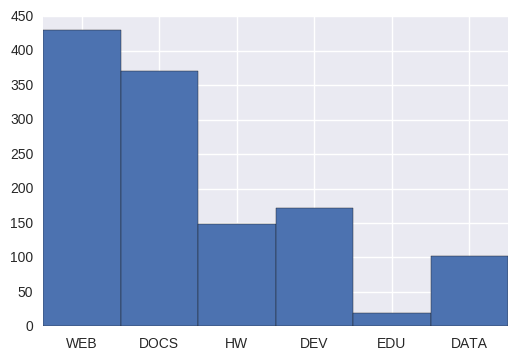

In [45]:
import pandas as pd
from collections import Counter
import numpy as np

labels, values = zip(*Counter(data_frame['label']).items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

100%|██████████| 10/10 [01:19<00:00,  7.12s/it]


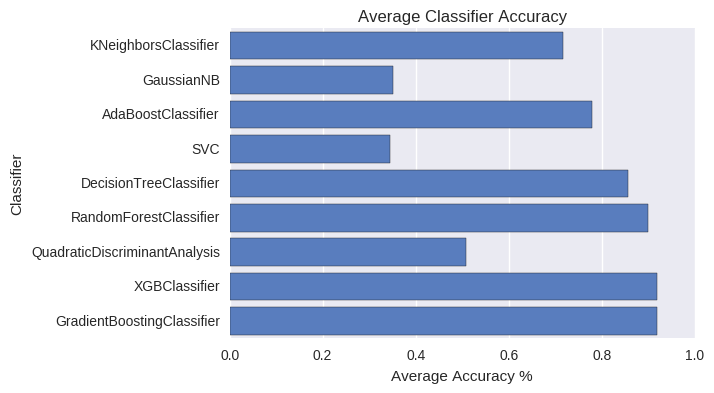

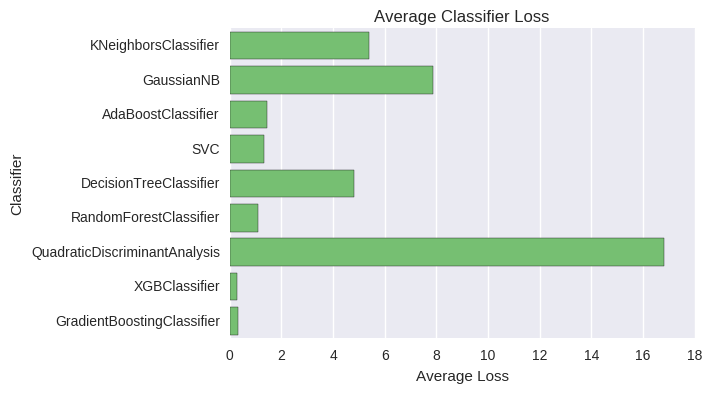

In [46]:
"""Compare 9 classifiers"""

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from tqdm import tqdm
sns.set_color_codes("muted")

#data_frame = pd.read_csv('data/processed_data.csv')


le = LabelEncoder().fit(data_frame.label) 
labels = le.transform(data_frame.label)
sss = StratifiedShuffleSplit(labels, 10, test_size=0.3, random_state=23)

data_frame.drop('readme', axis=1, inplace=True)
data_frame.drop('description', axis=1, inplace=True)
data_frame.drop('repository', axis=1, inplace=True)
data_frame.drop('owner', axis=1, inplace=True)
data_frame.drop('name', axis=1, inplace=True)
data_frame.drop('label', axis=1, inplace=True)
data_frame.fillna(0, inplace=True)

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    #NuSVC(probability=True),
    DecisionTreeClassifier(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    #LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    XGBClassifier()]

classifier_accs = {}
classifier_loss = {}
for clf in classifiers:
    classifier_accs[clf.__class__.__name__] = 0
    classifier_loss[clf.__class__.__name__] = 0

for train_index, test_index in tqdm(sss):
    X_train, X_test = data_frame.values[train_index], data_frame.values[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        classifier_accs[name] += acc

        train_predictions = clf.predict_proba(X_test)
        ll = log_loss(y_test, train_predictions)
        classifier_loss[name] += ll

avg_acc = {k: v / len(sss) for k, v in classifier_accs.iteritems()}
avg_loss = {k: v / len(sss) for k, v in classifier_loss.iteritems()}
avg_df = pd.DataFrame([[name, acc, avg_loss[name]] for name, acc in avg_acc.iteritems()], columns=['Classifier', 'Avg Accuracy', 'Avg Loss'])

sns.barplot(x='Avg Accuracy', y='Classifier', data=avg_df, color="b")
plt.xlabel('Average Accuracy %')
plt.title('Average Classifier Accuracy')
plt.show()

sns.barplot(x='Avg Loss', y='Classifier', data=avg_df, color="g")
plt.xlabel('Average Loss')
plt.title('Average Classifier Loss')
plt.show()

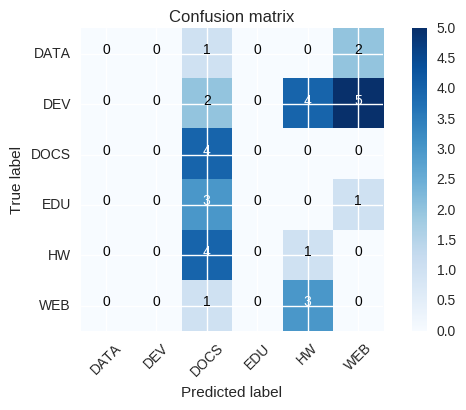

0.16129032258064516

In [47]:
"""Learn one classifier on the training set and evaluate it on the validation set"""

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsOneClassifier
from app.evaluation import get_accuracy_and_plot_confusion, get_training_and_validation_df

X_train, y_train, X_valid, y_valid = get_training_and_validation_df()

le = LabelEncoder().fit(y_train)
labels = le.transform(y_train)  
classes = le.classes_
acc = 0

clf = XGBClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_valid)
get_accuracy_and_plot_confusion(y_valid, y_pred, classes)

In [48]:
data_frame = get_cleaned_processed_df()
print len(data_frame)
training = pd.DataFrame(data_frame, columns=['repository', 'label'])
training["repository"] = training["repository"].apply(lambda x: "https://github.com/" + x)
training.to_csv("data/training_data.csv", index=False)

1242
